## Interpretability Figures (Fig5, FigS2) Reproduction

This notebook reproduces the composite interpretability figures from pre-generated CSV data files. 

### 1. Imports and Plotting Setup

In [1]:
import logging
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Basic Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Matplotlib Settings Helper ---
def _apply_matplotlib_settings(width_mm=180, height_mm=65):
    """Applies consistent matplotlib settings for publication-quality plots."""
    mm_to_inch = 1 / 25.4
    settings = {
        "text.usetex": False, "mathtext.default": "regular",
        "font.family": "sans-serif", "font.sans-serif": ["DejaVu Sans", "Arial", "sans-serif"],
        "font.size": 7, "legend.fontsize": 7, "axes.titlesize": 7,
        "axes.labelsize": 7, "xtick.labelsize": 7, "ytick.labelsize": 7,
        "axes.spines.top": False, "axes.spines.right": False, "axes.linewidth": 0.7,
        "xtick.major.width": 0.7, "ytick.major.width": 0.7, "savefig.dpi": 300,
        "figure.dpi": 150, "savefig.format": "pdf", "savefig.bbox": "tight",
        "pdf.fonttype": 42,
        "figure.figsize": (width_mm * mm_to_inch, height_mm * mm_to_inch),
    }
    plt.rcParams.update(settings)

def darken_color(hex_color, factor=0.7):
    """Darken a hex color by the given factor"""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * factor) for c in rgb)
    return f"#{darkened_rgb[0]:02x}{darkened_rgb[1]:02x}{darkened_rgb[2]:02x}"

### 2. Data Loading and Reshaping

Load the data from CSVs and reshape it into the dictionary format expected by the plotting functions.

In [2]:
def load_and_prepare_data(name_suffix: str, config: dict):
    """Loads all CSVs for a dataset and prepares them for plotting functions."""
    logging.info(f"──► Loading and preparing data for suffix: '{name_suffix}'")
    
    # --- Load Data from CSVs ---
    try:
        df_spatial = pd.read_csv(f"spatial_occlusion_data{name_suffix}.csv")
        df_freq = pd.read_csv(f"frequency_occlusion_data{name_suffix}.csv")
        df_spatio = pd.read_csv(f"spatio_spectral_occlusion_data{name_suffix}.csv")
    except FileNotFoundError as e:
        logging.error(f"Error loading CSV files: {e}. Make sure 'create_csv_data.py' has been run.")
        return None, None, None

    # --- Create MNE Info object (required for topomaps) ---
    ch_names = df_spatial['channel'].tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=config["SFREQ"], ch_types="eeg")
    info.set_montage(mne.channels.make_standard_montage("standard_1005"), match_case=False, on_missing="warn")

    # --- Reshape for Panel A ---
    spatial_data = {
        'grand_map': df_spatial['importance_percent'].to_numpy(),
        'info': info
    }

    # --- Reshape for Panel B ---
    freq_importance_data = df_freq.groupby('band')['importance_percent'].apply(list).to_dict()
    freq_data = {
        'importance_data': freq_importance_data,
        'bands': list(config["FREQ_BANDS"].keys())
    }
    
    # --- Reshape for Panel C ---
    spatio_spectral_map = {band: df_spatio[band].to_numpy() for band in config["FREQ_BANDS"]}
    spatio_spectral_data = {
        'grand_map': spatio_spectral_map,
        'info': info,
        'bands': list(config["FREQ_BANDS"].keys())
    }
    logging.info("✓ Data successfully prepared.")
    return spatial_data, freq_data, spatio_spectral_data

# --- Hardcoded analysis config from original script ---
ANALYSIS_CONFIG = {
    "N_CHANS": 60, "SFREQ": 1000,
    "FREQ_BANDS": {
        'Theta (4-8 Hz)': (4, 8), 'Alpha (8-13 Hz)': (8, 13),
        'Beta (13-25 Hz)': (13, 25), 'Gamma (25-47 Hz)': (25, 47),
    }
}

### 3. Panel Plotting Functions

These functions create the individual panels of the composite figure. They are identical to the original script.

In [3]:
def plot_spatial_on_ax(ax, data: dict):
    logging.info("  Plotting Panel A: Spatial Occlusion")
    delta_auc_values = data['grand_map']
    info = data['info']
    vmax = np.max(np.abs(delta_auc_values))
    if vmax == 0: vmax = 1e-9
    im, _ = mne.viz.plot_topomap(
        delta_auc_values, info, axes=ax, cmap="RdBu_r", vlim=(-vmax, vmax),
        show=False, sensors=False, outlines="head", extrapolate="head"
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label("Δ ROC AUC (%)")
    ax.set_title("Broadband", fontsize=7, y=0.95)

def plot_freq_on_ax(ax, data: dict):
    logging.info("  Plotting Panel B: Frequency Occlusion")
    importance_data, bands = data["importance_data"], data["bands"]
    fill_color = '#e1e1e0'
    edge_color = darken_color(fill_color)
    for i, band in enumerate(bands):
        band_data = [v for v in importance_data.get(band, []) if not np.isnan(v)]
        if not band_data:
            continue
        violin_parts = ax.violinplot(
            dataset=band_data, positions=[i], showmeans=False, showmedians=False,
            showextrema=False, widths=0.4, bw_method=0.2
        )
        for pc in violin_parts['bodies']:
            pc.set_facecolor(fill_color); pc.set_edgecolor(edge_color)
            pc.set_linewidth(0.5); pc.set_alpha(1.0); pc.set_zorder(1)
        bp = ax.boxplot(
            x=band_data, positions=[i], vert=True, patch_artist=True, widths=0.2,
            showfliers=False, whiskerprops={'color': edge_color, 'linewidth': 0.5, 'zorder': 2},
            capprops={'color': edge_color, 'linewidth': 0.5, 'zorder': 2},
            medianprops={'color': edge_color, 'linewidth': 0.8, 'zorder': 4},
        )
        for patch in bp['boxes']:
            patch.set_facecolor('w'); patch.set_edgecolor(edge_color)
            patch.set_linewidth(0.5); patch.set_zorder(3)
    ax.set_ylabel("Δ ROC AUC (%)")
    ax.set_xticks(np.arange(len(bands)))
    ax.set_xticklabels([b.split(" ")[0] for b in bands], rotation=45, ha="right")
    ax.tick_params(axis='x', length=3)
    ax.grid(False)

def plot_spatio_spectral_on_axes(fig, axes, data: dict):
    logging.info("  Plotting Panel C: Spatio-Spectral Occlusion")
    spatio_spectral_maps, info, bands = data["grand_map"], data["info"], data["bands"]
    all_vals = np.concatenate([v for v in spatio_spectral_maps.values() if v is not None and v.size > 0])
    global_vmax = np.max(np.abs(all_vals)) if all_vals.size > 0 else 1e-9
    mappable = None
    for i, band in enumerate(bands):
        ax = axes[i]
        delta_auc_values = spatio_spectral_maps.get(band)
        if delta_auc_values is None:
            ax.axis("off"); continue
        mappable, * _ = mne.viz.plot_topomap(
            delta_auc_values, info, axes=ax, cmap="RdBu_r", vlim=(-global_vmax, global_vmax),
            show=False, sensors=False, outlines="head", extrapolate="head"
        )
        ax.set_title(band.split(" ")[0], fontsize=7, y=0.95)
    return mappable

### 4. Generate and Save Composite Figure

This cell orchestrates the loading, plotting, and saving for a given dataset.

In [4]:
def generate_figure(name_suffix: str):
    # --- Load and Prepare Data ---
    spatial_data, freq_data, spatio_spectral_data = load_and_prepare_data(name_suffix, ANALYSIS_CONFIG)
    if not all([spatial_data, freq_data, spatio_spectral_data]):
        raise RuntimeError(f"Could not generate figure for '{name_suffix}' due to data loading errors.")
    
    # --- Apply Figure Settings ---
    _apply_matplotlib_settings(width_mm=180, height_mm=65)
    fig = plt.figure()
    fig.subplots_adjust(left=0.05, right=0.89, bottom=0.15, top=0.85)

    # --- Create Layout with Nested GridSpec ---
    gs_main = GridSpec(1, 2, figure=fig, width_ratios=[1.5, 5.0], wspace=0.4)
    gs_nested_bc = GridSpecFromSubplotSpec(
        3, 2, subplot_spec=gs_main[0, 1],
        width_ratios=[3.0, 2.0], wspace=0.15,
        height_ratios=[1, 3, 1]
    )

    # --- Panel A: Spatial Occlusion ---
    ax_spatial = fig.add_subplot(gs_main[0, 0])
    plot_spatial_on_ax(ax_spatial, spatial_data)
    ax_spatial.text(-0.15, 1.4, 'a', transform=ax_spatial.transAxes, fontsize=10, fontweight='bold')

    # --- Panel B: Frequency Occlusion ---
    ax_freq = fig.add_subplot(gs_nested_bc[1, 0])
    plot_freq_on_ax(ax_freq, freq_data)
    ax_b_label = fig.add_subplot(gs_nested_bc[0, 0])
    ax_b_label.text(-0.25, 1.2, 'b', transform=ax_b_label.transAxes, fontsize=10, fontweight='bold')
    ax_b_label.axis('off')

    # --- Panel C: Spatio-Spectral Occlusion ---
    gs_nested_c_spec = gs_nested_bc[:, 1]
    gs_nested_c = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_nested_c_spec, hspace=0.3, wspace=0.1)
    axes_spatio_spectral = [fig.add_subplot(gs_nested_c[i, j]) for i in range(2) for j in range(2)]
    mappable = plot_spatio_spectral_on_axes(fig, axes_spatio_spectral, spatio_spectral_data)
    axes_spatio_spectral[0].text(-0.25, 1.12, 'c', transform=axes_spatio_spectral[0].transAxes, fontsize=10, fontweight='bold')

    # --- Add Colorbar for Panel C ---
    if mappable:
        pos_bottom = axes_spatio_spectral[2].get_position()
        pos_top = axes_spatio_spectral[0].get_position()
        cbar_bottom = pos_bottom.y0
        cbar_height = pos_top.y1 - pos_bottom.y0
        cax = fig.add_axes([0.92, cbar_bottom, 0.015, cbar_height])
        cb = fig.colorbar(mappable, cax=cax)
        cb.set_label("Δ ROC AUC (%)")
        cb.ax.tick_params(labelsize=7)
        cb.outline.set_linewidth(0.7)

    # --- Finalize and Save ---
    output_file = f"composite_interpretability_figure_reproduced{name_suffix}.pdf"
    plt.savefig(output_file)
    logging.info(f"✓ Composite figure saved to: {output_file}")
    plt.show()

### 5. Execute for Both Datasets

2025-08-01 08:24:40,775 - INFO - ──► Loading and preparing data for suffix: ''
2025-08-01 08:24:41,518 - INFO - ✓ Data successfully prepared.
2025-08-01 08:24:41,533 - INFO -   Plotting Panel A: Spatial Occlusion
2025-08-01 08:24:41,697 - INFO -   Plotting Panel B: Frequency Occlusion
2025-08-01 08:24:41,748 - INFO -   Plotting Panel C: Spatio-Spectral Occlusion
2025-08-01 08:24:42,158 - INFO - maxp pruned
2025-08-01 08:24:42,166 - INFO - cmap pruned
2025-08-01 08:24:42,169 - INFO - kern dropped
2025-08-01 08:24:42,169 - INFO - post pruned
2025-08-01 08:24:42,170 - INFO - FFTM dropped
2025-08-01 08:24:42,172 - INFO - GPOS pruned
2025-08-01 08:24:42,175 - INFO - GSUB pruned
2025-08-01 08:24:42,180 - INFO - glyf pruned
2025-08-01 08:24:42,181 - INFO - Added gid0 to subset
2025-08-01 08:24:42,181 - INFO - Added first four glyphs to subset
2025-08-01 08:24:42,182 - INFO - Closing glyph list over 'GSUB': 7 glyphs before
2025-08-01 08:24:42,182 - INFO - Glyph names: ['.notdef', '.null', 'a',

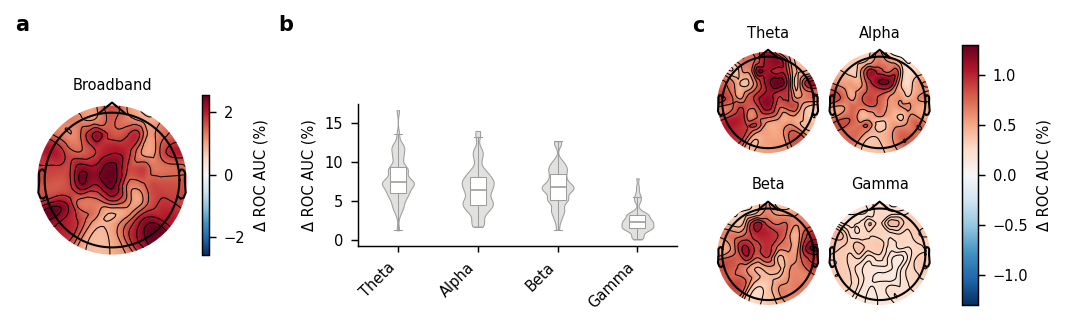

In [5]:
# Generate the main figure
generate_figure(name_suffix="")

2025-08-01 08:24:45,346 - INFO - ──► Loading and preparing data for suffix: '_p60'
2025-08-01 08:24:45,364 - INFO - ✓ Data successfully prepared.
2025-08-01 08:24:45,370 - INFO -   Plotting Panel A: Spatial Occlusion
2025-08-01 08:24:45,398 - INFO -   Plotting Panel B: Frequency Occlusion
2025-08-01 08:24:45,443 - INFO -   Plotting Panel C: Spatio-Spectral Occlusion
2025-08-01 08:24:45,719 - INFO - maxp pruned
2025-08-01 08:24:45,727 - INFO - cmap pruned
2025-08-01 08:24:45,727 - INFO - kern dropped
2025-08-01 08:24:45,727 - INFO - post pruned
2025-08-01 08:24:45,728 - INFO - FFTM dropped
2025-08-01 08:24:45,730 - INFO - GPOS pruned
2025-08-01 08:24:45,733 - INFO - GSUB pruned
2025-08-01 08:24:45,737 - INFO - glyf pruned
2025-08-01 08:24:45,738 - INFO - Added gid0 to subset
2025-08-01 08:24:45,738 - INFO - Added first four glyphs to subset
2025-08-01 08:24:45,738 - INFO - Closing glyph list over 'GSUB': 7 glyphs before
2025-08-01 08:24:45,739 - INFO - Glyph names: ['.notdef', '.null', 

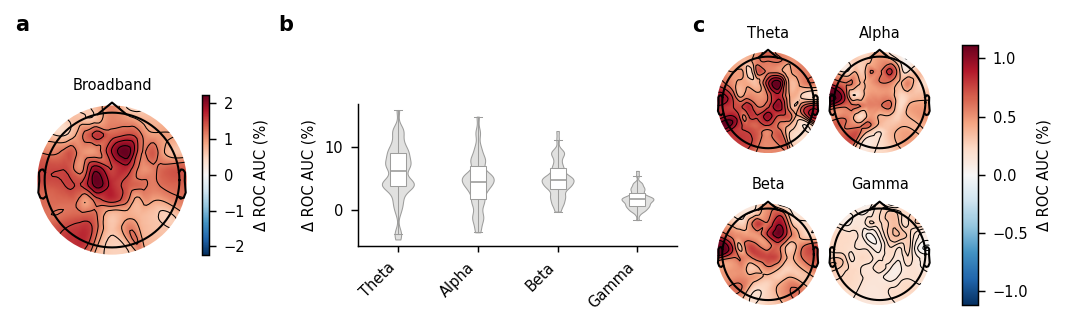

In [6]:
# Generate the p60 figure
generate_figure(name_suffix="_p60")